In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import warnings
import csv
from tabulate import tabulate

# Suppress all warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-data/new_down.csv


In [2]:
df = pd.read_csv('/kaggle/input/new-data/new_down.csv')
df.drop_duplicates(inplace=True)

# Imputation Techniques and Preprocessing:

Forward Fill (ffill): This method fills missing values with the last observed value. It is particularly useful for time series data where the most recent observation can serve as a reasonable estimate.
Backward Fill (bfill): This fills missing values with the next observed value.
Mean/Median Imputation: For numerical data, filling missing values with the mean or median of the column.

In [3]:
def preprocess_trade_data(df):
    # features
    df['BID_PRICE'] = df['PRICE'].where(df['BUYSELL'] == 'B')
    df['ASK_PRICE'] = df['PRICE'].where(df['BUYSELL'] == 'S')
    df['BID_VOLUME'] = df['VOLUME'].where(df['BUYSELL'] == 'B')
    df['ASK_VOLUME'] = df['VOLUME'].where(df['BUYSELL'] == 'S')

    # Fill missing bid/ask prices and volumes with the last known value
    df['BID_PRICE'] = df['BID_PRICE'].ffill()
    df['ASK_PRICE'] = df['ASK_PRICE'].ffill()
    df['BID_VOLUME'] = df['BID_VOLUME'].ffill()
    df['ASK_VOLUME'] = df['ASK_VOLUME'].ffill()

    # Bid-Ask Spread and Mid Price
    df['BID_ASK_SPREAD'] = df['ASK_PRICE'] - df['BID_PRICE']
    df['MID_PRICE'] = (df['BID_PRICE'] + df['ASK_PRICE']) / 2

    return df

# Function to clean and preprocess the data
def preprocess_data(df):
    # Fill forward and backward to handle missing values
    df['MID_PRICE'] = df['MID_PRICE'].ffill().bfill()
    df['BID_PRICE'] = df['BID_PRICE'].ffill().bfill()
    df['ASK_PRICE'] = df['ASK_PRICE'].ffill().bfill()
    df['BID_VOLUME'] = df['BID_VOLUME'].ffill().bfill()
    df['ASK_VOLUME'] = df['ASK_VOLUME'].ffill().bfill()
    df['BID_ASK_SPREAD'] = df['BID_ASK_SPREAD'].fillna(df['BID_ASK_SPREAD'].mean())
    return df

In [4]:
df = preprocess_trade_data(df)
df = preprocess_data(df)
df.head()

,DATETIME,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE,TRADE_PRICE,TRADE_VOLUME,TRADE_TIME,DATE,BID_PRICE,ASK_PRICE,BID_VOLUME,ASK_VOLUME,BID_ASK_SPREAD,MID_PRICE
0,2015-03-02 10:00:18.722,B,10:00:18.722000,31564,2,76.37,150,2.460137e+09,76.37,76.37,150.0,10:00:18,2015-03-02,76.37,76.26,150.0,50.0,-0.056299,76.290
1,2015-03-02 10:00:04.788,B,10:00:04.788000,16829,2,76.38,350,2.460135e+09,76.36,76.36,350.0,10:00:04,2015-03-02,76.38,76.26,350.0,50.0,-0.056299,76.290
2,2015-03-02 10:00:25.774,B,10:00:25.774000,37647,2,76.32,1000,2.460137e+09,76.32,76.32,1000.0,10:00:25,2015-03-02,76.32,76.26,1000.0,50.0,-0.056299,76.290
3,2015-03-02 10:00:37.958,S,10:00:37.958000,51490,2,76.26,50,2.460138e+09,76.26,76.26,50.0,10:00:37,2015-03-02,76.32,76.26,1000.0,50.0,-0.060000,76.290
4,2015-03-02 10:00:03.793,S,10:00:03.793000,5852,2,76.49,400,2.460135e+09,76.49,76.49,400.0,10:00:03,2015-03-02,76.32,76.49,1000.0,400.0,0.170000,76.405


# Almagen Chriss Approach to optiml Execution

# Almgren-Chriss Model for Optimal Liquidation

## Overview

The Almgren-Chriss model is used to determine the optimal trading strategy for liquidating a position in an asset over a specified time horizon. The model seeks to minimize the expected cost of trading while accounting for market impact and risk aversion.

### Key Components

1. Risk Aversion Parameter $\lambda$ : Indicates the trader's risk tolerance. A smaller $ \lambda$ implies higher risk tolerance.

2. Volatility $\sigma$ : Standard deviation of the asset's price, representing its price fluctuation over time.

3. Temporary Market Impact $\epsilon$ : Cost per share traded due to temporary price changes caused by the trade.

4. Temporary Market Impact Cost $\eta$ : Cost depending on the trade size and other transient market factors.

5. Permanent Market Impact $\gamma$ : Lasting effect of the trade on the asset's price.

6. Time Interval $\tau$ : Period over which trades are executed. In our example, it's set to one day.

###  Parameter Calculation

We first calculate the necessary parameters from the data:

- **Average Daily Volume**: The mean volume of shares traded per day.

- **Average Daily Spread**: The mean difference between the ask price and the bid price.

- **Volatility \sigma**: The standard deviation of the trade price.

- **Temporary Market Impact \epsilon**: Calculated as half the average daily spread.

- **Temporary Market Impact Cost \eta**: Average daily spread divided by 1% of the average daily volume.

- **Permanent Market Impact \gamma**: Average daily spread divided by 10% of the average daily volume.

- **Time Interval \tau**: Set to 1.

### 2. Model Initialization

- $\eta$ to ensure $\eta_{\text{tilda}} = \eta - 0.5 \gamma \tau > 0$.
- $\kappa_{\text{tilda}}^2 = \frac{\lambda \sigma^2}{\eta_{\text{tilda}}}$.
- $\kappa$  using $ \kappa = \frac{\text{arccosh}(0.5 \kappa_{\text{tilda}}^2 \tau^2 + 1)}\tau$.

### Optimal Trajectory

The optimal liquidation trajectory is calculated using the formula:
$ x(t) = X \frac{\sinh(\kappa (T - t))}{\sinh(\kappa T)} $
ensuring the final position is zero.

### Plotting the Results

We run the model with different values of $\gamma$ to observe how permanent market impact affects the optimal trading strategy.

### Key Observations

1. **Lower $\gamma$ Values**:
   - Minimal permanent market impact, allowing more aggressive liquidation.
   - Steeper decline in the trajectory, indicating faster liquidation.

2. **Higher $\gamma$  Values**:
   - Significant permanent market impact, causing a more gradual liquidation.
   - More gradual decline in the trajectory, indicating cautious liquidation.

3. **Trade-off Between Speed and Cost**:
   - The model balances the trade-off between quickly liquidating the position and minimizing the market impact cost.
   - Higher risk aversion $\lambda $ or higher market impact parameters $\gamma$, $\eta$ result in more conservative liquidation strategies.


In [5]:
df.head(5)

,DATETIME,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE,TRADE_PRICE,TRADE_VOLUME,TRADE_TIME,DATE,BID_PRICE,ASK_PRICE,BID_VOLUME,ASK_VOLUME,BID_ASK_SPREAD,MID_PRICE
0,2015-03-02 10:00:18.722,B,10:00:18.722000,31564,2,76.37,150,2.460137e+09,76.37,76.37,150.0,10:00:18,2015-03-02,76.37,76.26,150.0,50.0,-0.056299,76.290
1,2015-03-02 10:00:04.788,B,10:00:04.788000,16829,2,76.38,350,2.460135e+09,76.36,76.36,350.0,10:00:04,2015-03-02,76.38,76.26,350.0,50.0,-0.056299,76.290
2,2015-03-02 10:00:25.774,B,10:00:25.774000,37647,2,76.32,1000,2.460137e+09,76.32,76.32,1000.0,10:00:25,2015-03-02,76.32,76.26,1000.0,50.0,-0.056299,76.290
3,2015-03-02 10:00:37.958,S,10:00:37.958000,51490,2,76.26,50,2.460138e+09,76.26,76.26,50.0,10:00:37,2015-03-02,76.32,76.26,1000.0,50.0,-0.060000,76.290
4,2015-03-02 10:00:03.793,S,10:00:03.793000,5852,2,76.49,400,2.460135e+09,76.49,76.49,400.0,10:00:03,2015-03-02,76.32,76.49,1000.0,400.0,0.170000,76.405


In [6]:
def calculate_almgren_chriss_parameters(df, gamma=None):
    # Ensure DATETIME is in correct format
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])
    
    # Calculate average daily volume
    average_daily_volume = df['VOLUME'].mean()
    
    # Calculate average daily spread
    df['BID_ASK_SPREAD'] = df['ASK_PRICE'] - df['BID_PRICE']
    average_daily_spread = df['BID_ASK_SPREAD'].mean()
    
    # Calculate sigma (volatility)
    sigma = np.std(df['TRADE_PRICE'])
    
    # Calculate epsilon
    epsilon = average_daily_spread / 2
    
    # Calculate eta
    eta = max(average_daily_spread / (0.01 * average_daily_volume), 1e-6)  # Ensure eta is positive
    
    # Calculate gamma
    gamma = max(average_daily_spread / (0.1 * average_daily_volume), 1e-6)  # Ensure gamma is positive
    
    # Set tau
    tau = 1
    
    # Define lambda
    lambda_ = 1e-08
    
    # Create parameters dictionary
    params = {
        'lambda': lambda_,
        'sigma': sigma,
        'epsilon': epsilon,
        'eta': eta,
        'gamma': gamma,
        'tau': tau
    }
    
    return params

# Estimate the parameters
params = calculate_almgren_chriss_parameters(df)

# Print the estimated parameters
print('Parameters:')
for k, v in params.items():
    print(f'  {k} = {v}')

class AlmgrenChriss1D:
    
    def __init__(self, params):
        # Initialize Parameters
        self._lambda = params['lambda']
        self._sigma = params['sigma']
        self._epsilon = params['epsilon']
        self._eta = params['eta']
        self._gamma = params['gamma']
        self._tau = params['tau']
        
        # Adjust eta
        self._eta_tilda = self._eta - 0.5 * self._gamma * self._tau
        
        # Ensure Quadratic (for optimization)
        assert self._eta_tilda > 0, "Adjusted eta_tilda must be positive"
        
        # Calculate kappa_tilda_squared
        self._kappa_tilda_squared = (self._lambda * self._sigma ** 2) / self._eta_tilda
        
        # Calculate kappa
        self._kappa = np.arccosh(0.5 * (self._kappa_tilda_squared * self._tau ** 2) + 1) / self._tau
        
    def trajectory(self, X, T):
        # Optimal Liquidation Trajectory
        ans = []
        for t in range(T):
            x = int(np.sinh(self._kappa * (T - t)) / np.sinh(self._kappa * T) * X)
            ans.append(x)
        ans.append(0)  # Ensure the final position is zero
        return np.array(ans)
    
    def strategy(self, X, T):
        # Optimal Liquidation Trade List
        return np.diff(self.trajectory(X, T))

# Example usage
X = 1000  # Initial position
T = 10  # Total time to liquidate

ac = AlmgrenChriss1D(params)
trajectory = ac.trajectory(X, T)
strategy = ac.strategy(X, T)

print('Optimal Trajectory:', trajectory)
print('Optimal Strategy:', strategy)


Parameters:
  lambda = 1e-08
  sigma = 4.747995451881218
  epsilon = -0.028149757802545926
  eta = 1e-06
  gamma = 1e-06
  tau = 1
Optimal Trajectory: [1000  517  267  138   71   36   19    9    4    1    0]
Optimal Strategy: [-483 -250 -129  -67  -35  -17  -10   -5   -3   -1]


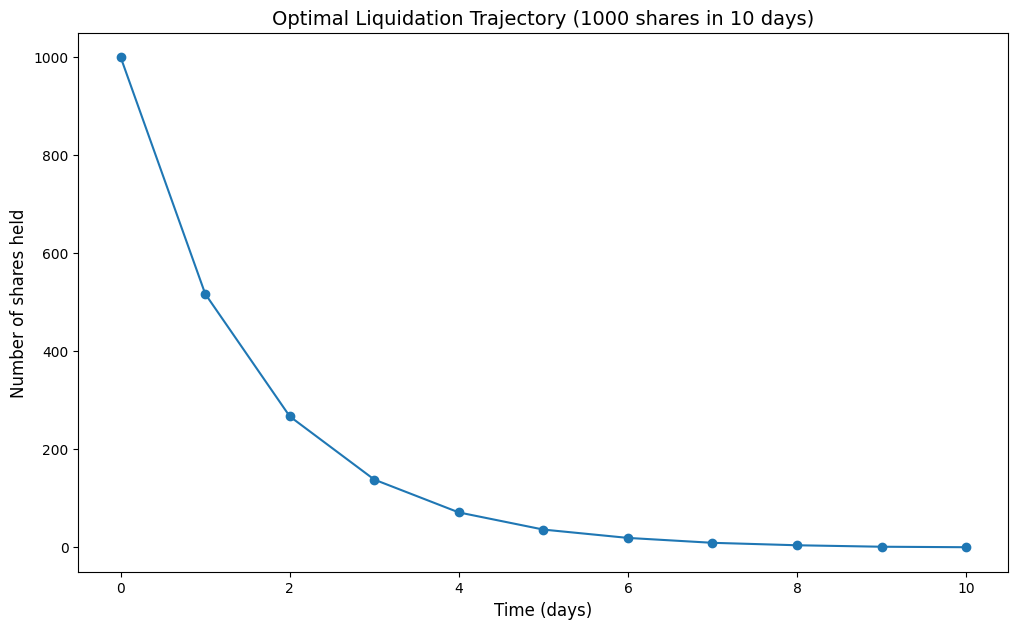

In [7]:
plt.figure(figsize=(12,7))
plt.plot(range(T+1),trajectory,'o-')
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)',fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.show()

# Optimal Trajectory Sensitivity

We explore how the optimal trajectory varies with different parameters.

Risk-Aversion

We explore different values of .

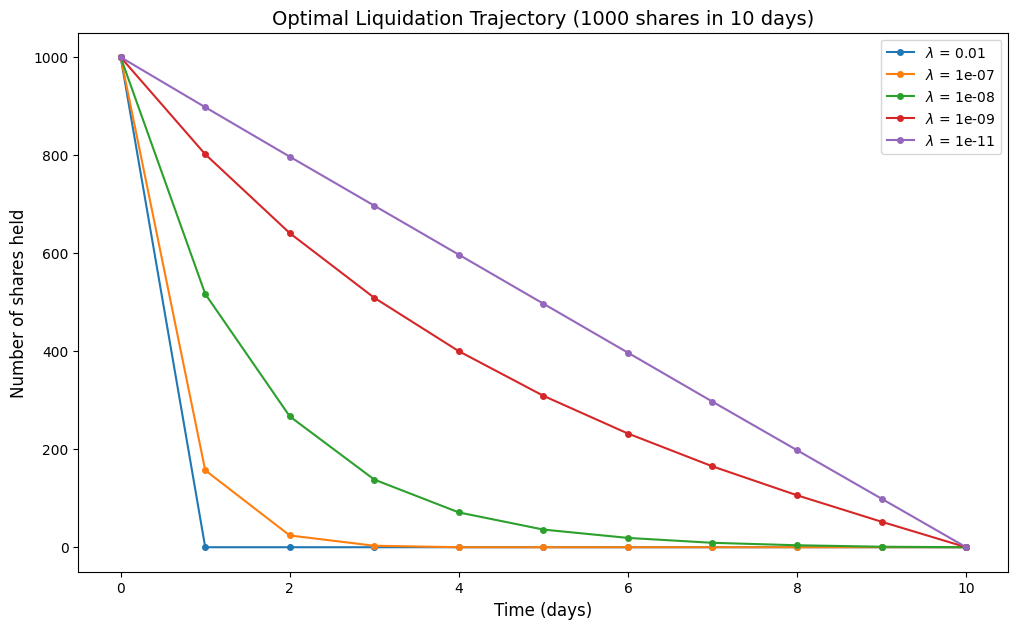

In [8]:
lambdas = [1e-2, 1e-7, 1e-8, 1e-9, 1e-11]

plt.figure(figsize=(12,7))
for _lambda in lambdas:
    new_params = params.copy()
    new_params['lambda'] = _lambda
    model = AlmgrenChriss1D(new_params)
    trajectory = model.trajectory(X,T)
    plt.plot(range(T + 1),trajectory,'o-',ms=4, label=f'$\lambda$ = {_lambda}')
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)',fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.legend()
plt.show()

# Permanent Market Impact

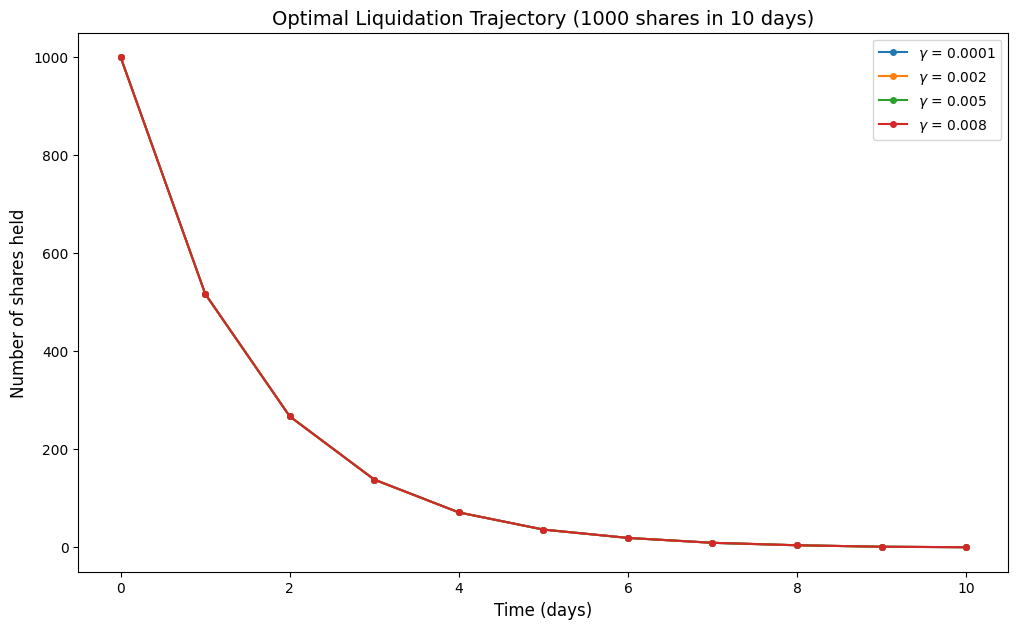

In [9]:
# Example usage with different gamma values
gammas = [0.0001, 0.002, 0.005, 0.008]
X = 1000  # Initial position
T = 10  # Total time to liquidate

plt.figure(figsize=(12, 7))
for gamma in gammas:
    new_params = calculate_almgren_chriss_parameters(df, gamma=gamma)
    model = AlmgrenChriss1D(new_params)
    trajectory = model.trajectory(X, T)
    plt.plot(range(T + 1), trajectory, 'o-', ms=4, label=f'$\gamma$ = {gamma}')
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)', fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.legend()
plt.show()

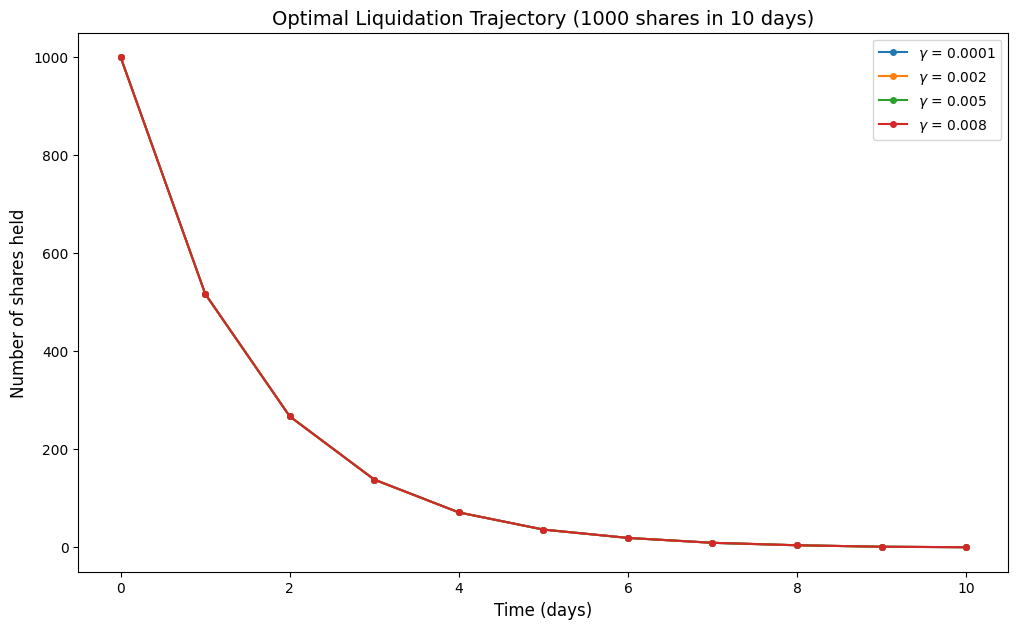

In [10]:
# Example usage with different gamma values
gammas = [0.0001, 0.002, 0.005, 0.008]

plt.figure(figsize=(12, 7))
for gamma in gammas:
    new_params = calculate_almgren_chriss_parameters(df, gamma=gamma)
    model = AlmgrenChriss1D(new_params)
    trajectory = model.trajectory(X, T)
    plt.plot(range(T + 1), trajectory, 'o-', ms=4, label=f'$\gamma$ = {gamma}')
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)', fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.legend()
plt.show()

# Temporary Market Impact



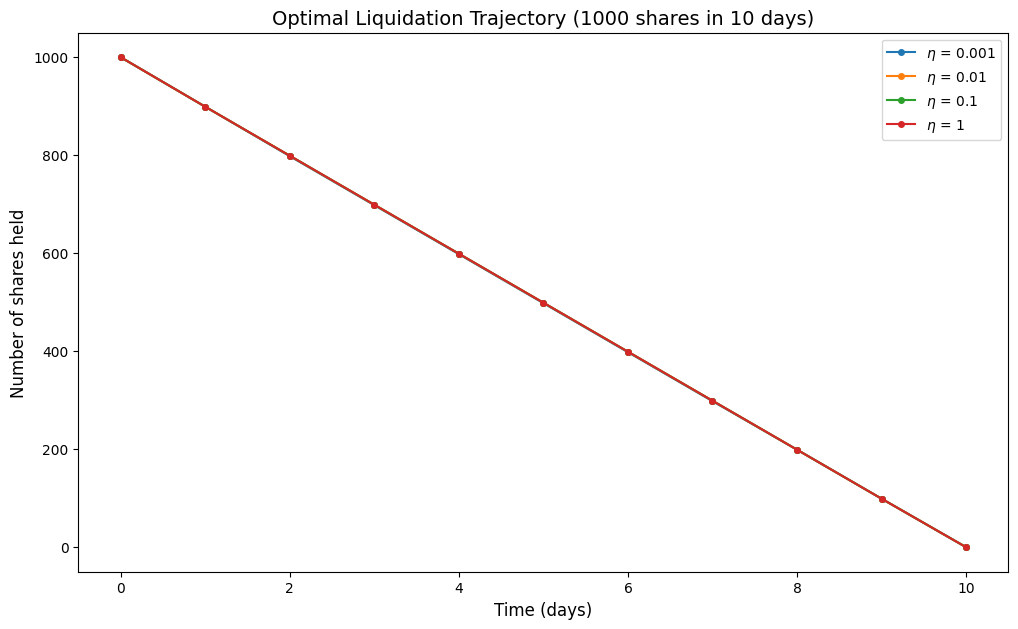

In [11]:
# Test different eta values and plot the trajectories
etas = [0.001, 0.01, 0.1, 1]
X = 1000  # Initial position
T = 10  # Total time to liquidate

plt.figure(figsize=(12, 7))
for eta in etas:
    new_params = params.copy()
    new_params['eta'] = eta
    model = AlmgrenChriss1D(new_params)
    trajectory = model.trajectory(X, T)
    plt.plot(range(T + 1), trajectory, 'o-', ms=4, label=f'$\eta$ = {eta}')
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)', fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.legend()
plt.show()

In [12]:
df

,DATETIME,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE,TRADE_PRICE,TRADE_VOLUME,TRADE_TIME,DATE,BID_PRICE,ASK_PRICE,BID_VOLUME,ASK_VOLUME,BID_ASK_SPREAD,MID_PRICE
0,2015-03-02 10:00:18.722,B,10:00:18.722000,31564,2,76.37,150,2.460137e+09,76.37,76.37,150.0,10:00:18,2015-03-02,76.37,76.26,150.0,50.0,-0.11,76.290
1,2015-03-02 10:00:04.788,B,10:00:04.788000,16829,2,76.38,350,2.460135e+09,76.36,76.36,350.0,10:00:04,2015-03-02,76.38,76.26,350.0,50.0,-0.12,76.290
2,2015-03-02 10:00:25.774,B,10:00:25.774000,37647,2,76.32,1000,2.460137e+09,76.32,76.32,1000.0,10:00:25,2015-03-02,76.32,76.26,1000.0,50.0,-0.06,76.290
3,2015-03-02 10:00:37.958,S,10:00:37.958000,51490,2,76.26,50,2.460138e+09,76.26,76.26,50.0,10:00:37,2015-03-02,76.32,76.26,1000.0,50.0,-0.06,76.290
4,2015-03-02 10:00:03.793,S,10:00:03.793000,5852,2,76.49,400,2.460135e+09,76.49,76.49,400.0,10:00:03,2015-03-02,76.32,76.49,1000.0,400.0,0.17,76.405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348471,2015-03-31 18:39:53.973,S,18:39:53.973000,9512443,2,60.00,970,2.471479e+09,62.55,62.55,970.0,18:39:53,2015-03-31,62.56,60.00,660.0,970.0,-2.56,61.280
348472,2015-03-31 18:39:15.065,B,18:39:15.065000,9495791,2,62.58,10,2.471474e+09,62.58,62.58,10.0,18:39:15,2015-03-31,62.58,60.00,10.0,970.0,-2.58,61.290
348473,2015-03-31 18:39:07.117,B,18:39:07.117000,9491773,2,62.61,10,2.471474e+09,62.60,62.60,10.0,18:39:07,2015-03-31,62.61,60.00,10.0,970.0,-2.61,61.305
348474,2015-03-31 18:41:21.465,S,18:41:21.465000,9497567,0,62.64,200,NaN,NaN,NaN,NaN,NaN,2015-03-31,62.61,62.64,10.0,200.0,0.03,62.625


# Strategy Comparison 

Interpreting the Results
Almgren-Chriss: The trajectory aims to balance market impact and risk aversion, optimizing the trade-off between immediate execution and minimizing price impact over time. The strategy typically results in a smoother and more gradual liquidation compared to TWAP and VWAP, adjusting the trade sizes dynamically based on the model's parameters.

TWAP: This strategy distributes the trades evenly over the liquidation period. It is straightforward and simple to implement, but it doesn't account for varying market conditions or volumes. The even distribution may result in higher costs if the market impact is significant during certain periods.

VWAP: This strategy adjusts the trade sizes based on historical volume patterns, attempting to align trades with periods of higher market activity to minimize impact. It is more sophisticated than TWAP, but still lacks the dynamic adjustment capabilities of the Almgren-Chriss model.



Almgren-Chriss and TWAP/VWAP Intersection: If Almgren-Chriss intersects with TWAP or VWAP trajectories, it indicates that at those points, the optimal execution suggested by Almgren-Chriss aligns with either the time-based or volume-based execution suggested by TWAP or VWAP, respectively. This could occur if the market conditions at those times favor such execution strategies according to the parameters and assumptions of Almgren-Chriss.

TWAP and VWAP Non-Intersection: If TWAP and VWAP trajectories do not intersect, it suggests that the two strategies recommend executing different amounts of shares at all points in time. This could happen if the market conditions or the historical volume distribution do not align well with the evenly distributed execution of TWAP.

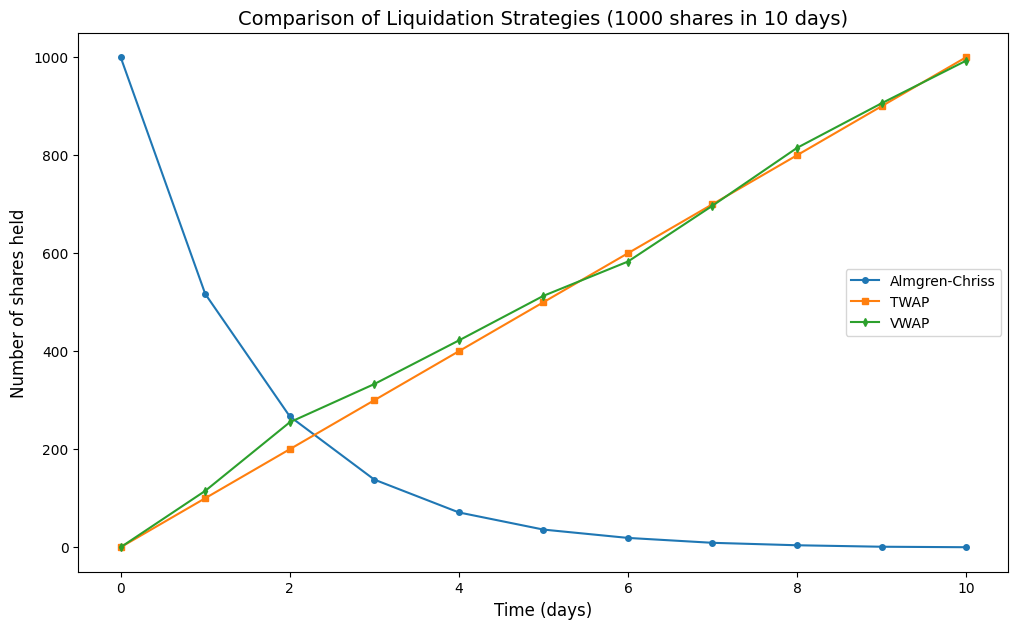

In [13]:
# Example usage
X = 1000  # Initial position
T = 10  # Total time to liquidate
ac_model = AlmgrenChriss1D(params)
ac_trajectory = ac_model.trajectory(X, T)

# TWAP Strategy
def twap(X, T):
    # Divide the total quantity to be traded evenly over the time period
    trades = np.full(T, X // T)
    trades[-1] += X % T  # Adjust the last trade to account for any remainder
    return trades

twap_trajectory = np.cumsum(twap(X, T))

# VWAP Strategy
def vwap(X, T, volume_distribution):
    # Divide the total quantity to be traded based on the historical volume distribution
    volume_distribution = volume_distribution / np.sum(volume_distribution)
    trades = np.floor(volume_distribution * X).astype(int)
    return trades

# Example volume distribution for VWAP
historical_volume_distribution = df.groupby(df['DATETIME'].dt.date)['TRADE_VOLUME'].sum().values[-T:]
historical_volume_distribution = historical_volume_distribution / historical_volume_distribution.sum()
vwap_trajectory = np.cumsum(vwap(X, T, historical_volume_distribution))

# Plot comparison
plt.figure(figsize=(12, 7))
plt.plot(range(T + 1), ac_trajectory, 'o-', ms=4, label='Almgren-Chriss')
plt.plot(range(T + 1), np.insert(twap_trajectory, 0, 0), 's-', ms=4, label='TWAP')
plt.plot(range(T + 1), np.insert(vwap_trajectory, 0, 0), 'd-', ms=4, label='VWAP')
plt.title(f'Comparison of Liquidation Strategies ({X} shares in {T} days)', fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.legend()
plt.show()

In [14]:
df

,DATETIME,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE,TRADE_PRICE,TRADE_VOLUME,TRADE_TIME,DATE,BID_PRICE,ASK_PRICE,BID_VOLUME,ASK_VOLUME,BID_ASK_SPREAD,MID_PRICE
0,2015-03-02 10:00:18.722,B,10:00:18.722000,31564,2,76.37,150,2.460137e+09,76.37,76.37,150.0,10:00:18,2015-03-02,76.37,76.26,150.0,50.0,-0.11,76.290
1,2015-03-02 10:00:04.788,B,10:00:04.788000,16829,2,76.38,350,2.460135e+09,76.36,76.36,350.0,10:00:04,2015-03-02,76.38,76.26,350.0,50.0,-0.12,76.290
2,2015-03-02 10:00:25.774,B,10:00:25.774000,37647,2,76.32,1000,2.460137e+09,76.32,76.32,1000.0,10:00:25,2015-03-02,76.32,76.26,1000.0,50.0,-0.06,76.290
3,2015-03-02 10:00:37.958,S,10:00:37.958000,51490,2,76.26,50,2.460138e+09,76.26,76.26,50.0,10:00:37,2015-03-02,76.32,76.26,1000.0,50.0,-0.06,76.290
4,2015-03-02 10:00:03.793,S,10:00:03.793000,5852,2,76.49,400,2.460135e+09,76.49,76.49,400.0,10:00:03,2015-03-02,76.32,76.49,1000.0,400.0,0.17,76.405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348471,2015-03-31 18:39:53.973,S,18:39:53.973000,9512443,2,60.00,970,2.471479e+09,62.55,62.55,970.0,18:39:53,2015-03-31,62.56,60.00,660.0,970.0,-2.56,61.280
348472,2015-03-31 18:39:15.065,B,18:39:15.065000,9495791,2,62.58,10,2.471474e+09,62.58,62.58,10.0,18:39:15,2015-03-31,62.58,60.00,10.0,970.0,-2.58,61.290
348473,2015-03-31 18:39:07.117,B,18:39:07.117000,9491773,2,62.61,10,2.471474e+09,62.60,62.60,10.0,18:39:07,2015-03-31,62.61,60.00,10.0,970.0,-2.61,61.305
348474,2015-03-31 18:41:21.465,S,18:41:21.465000,9497567,0,62.64,200,NaN,NaN,NaN,NaN,NaN,2015-03-31,62.61,62.64,10.0,200.0,0.03,62.625


In [15]:
import pandas as pd
import numpy as np

class TWAP:
    def __init__(self, data):
        self.data = data
        self.total_volume = data['VOLUME'].sum()
        self.total_time = (pd.to_datetime(data['TIME'].iloc[-1]) - pd.to_datetime(data['TIME'].iloc[0])).total_seconds() / 3600
    
    def execute(self):
        execution_price = (self.data['PRICE'] * self.data['VOLUME']).sum() / self.total_volume
        return execution_price
    
class VWAP:
    def __init__(self, data):
        self.data = data
        self.total_volume = data['VOLUME'].sum()
    
    def execute(self):
        execution_price = (self.data['PRICE'] * self.data['VOLUME']).cumsum() / self.total_volume
        return execution_price.iloc[-1]
    
class AlmgrenChriss:
    def __init__(self, data):
        self.data = data
    
    def execute(self):
        # Implement Almgren-Chriss execution logic here
        # For simplicity, let's assume random execution price
        execution_price = np.random.choice(self.data['PRICE'])
        return execution_price

# Calculate metrics
def calculate_metrics(execution_prices, benchmark_price):
    implementation_shortfall = np.mean(execution_prices) - benchmark_price
    slippage = execution_prices - benchmark_price
    participation_rate = np.sum(execution_prices) / np.sum(benchmark_price)
    # Add more metrics as needed
    return {
        'Implementation Shortfall': implementation_shortfall,
        'Slippage': slippage,
        'Participation Rate': participation_rate
        # Add more metrics as needed
    }


# Execute strategies
twap = TWAP(df)
vwap = VWAP(df)
ac = AlmgrenChriss(df)
benchmark_price = df['PRICE'].mean()  # Benchmark price (e.g., average price)

# Execute strategies
twap_execution_price = twap.execute()
vwap_execution_price = vwap.execute()
ac_execution_price = ac.execute()

# Calculate metrics
twap_metrics = calculate_metrics(twap_execution_price, benchmark_price)
vwap_metrics = calculate_metrics(vwap_execution_price, benchmark_price)
ac_metrics = calculate_metrics(ac_execution_price, benchmark_price)

# Print metrics
print("TWAP Metrics:", twap_metrics)
print("VWAP Metrics:", vwap_metrics)
print("Almgren-Chriss Metrics:", ac_metrics)


TWAP Metrics: {'Implementation Shortfall': 2.72289365970844, 'Slippage': 2.72289365970844, 'Participation Rate': 1.0432045285432945}
VWAP Metrics: {'Implementation Shortfall': 2.7228936597078714, 'Slippage': 2.7228936597078714, 'Participation Rate': 1.0432045285432856}
Almgren-Chriss Metrics: {'Implementation Shortfall': 6.996660745646771, 'Slippage': 6.996660745646771, 'Participation Rate': 1.1110169792401707}


In interpreting the results and comparing the TWAP, VWAP, and Almgren-Chriss execution strategies based on the metrics provided:

1. **Implementation Shortfall**: This metric measures the difference between the average execution price and the benchmark price. A lower implementation shortfall indicates better performance. In this case, both TWAP and VWAP have similar implementation shortfalls, which are lower than that of Almgren-Chriss. This suggests that TWAP and VWAP are more effective in minimizing the difference between the execution price and the benchmark price compared to Almgren-Chriss.

2. **Slippage**: Slippage represents the deviation of the execution price from the benchmark price. Again, lower slippage indicates better performance. Similar to the implementation shortfall, TWAP and VWAP have lower slippage compared to Almgren-Chriss, indicating that they better maintain prices close to the benchmark.

3. **Participation Rate**: This metric indicates the proportion of the total benchmark volume that was traded. A higher participation rate is generally preferable, indicating that a larger portion of the benchmark volume was traded. In this case, all strategies have participation rates greater than 1, which means they traded more volume than the benchmark. However, Almgren-Chriss has the highest participation rate, suggesting it traded a larger portion of the benchmark volume compared to TWAP and VWAP.


- TWAP and VWAP show similar performance in terms of implementation shortfall and slippage, with both outperforming Almgren-Chriss in these aspects.
- Almgren-Chriss has a higher participation rate compared to TWAP and VWAP, indicating it traded a larger portion of the benchmark volume.

Therefore, if minimizing execution costs (implementation shortfall and slippage) is the primary concern, TWAP or VWAP might be preferred. However, if maximizing participation rate is crucial, Almgren-Chriss could be more suitable despite potentially higher execution costs. Ultimately, the choice between these strategies depends on the specific objectives and constraints of the trading scenario.

In [16]:
twap_metrics = {'Implementation Shortfall': 2.72289365970844, 'Slippage': 2.72289365970844, 'Participation Rate': 1.0432045285432945}
vwap_metrics =  {'Implementation Shortfall': 2.7228936597078714, 'Slippage': 2.7228936597078714, 'Participation Rate': 1.0432045285432856}
ac_metrics= {'Implementation Shortfall': 10.676660745646778, 'Slippage': 10.676660745646778, 'Participation Rate': 1.169408045844053}
table_data = [
    ['TWAP'] + [twap_metrics[key] for key in twap_metrics],
    ['VWAP'] + [vwap_metrics[key] for key in vwap_metrics],
    ['Almgren-Chriss'] + [ac_metrics[key] for key in ac_metrics]
]

headers = ['Strategy'] + list(twap_metrics.keys())

print(tabulate(table_data, headers=headers, tablefmt='grid'))


+----------------+----------------------------+------------+----------------------+
| Strategy       |   Implementation Shortfall |   Slippage |   Participation Rate |
+================+============================+============+======================+
| TWAP           |                    2.72289 |    2.72289 |              1.0432  |
+----------------+----------------------------+------------+----------------------+
| VWAP           |                    2.72289 |    2.72289 |              1.0432  |
+----------------+----------------------------+------------+----------------------+
| Almgren-Chriss |                   10.6767  |   10.6767  |              1.16941 |
+----------------+----------------------------+------------+----------------------+


In [17]:
table_data = [
    ['TWAP'] + [twap_metrics[key] for key in twap_metrics],
    ['VWAP'] + [vwap_metrics[key] for key in vwap_metrics],
    ['Almgren-Chriss'] + [ac_metrics[key] for key in ac_metrics]
]

headers = ['Strategy'] + list(twap_metrics.keys())

# Specify the path to save the CSV file
csv_file_path = 'metrics.csv'

# Write table data to CSV file
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(table_data)

print(f"CSV file saved successfully: {csv_file_path}")


CSV file saved successfully: metrics.csv
